In [10]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [11]:
import logging
import os
import pickle
from typing import List, Tuple, Type

import numpy as np
import geopandas as gpd
import rasterio
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

from src.data_loading.rasterio_utils import get_thumbnail
from src.unet.satellite_image import SatelliteImage
from src.unet.dataloader import SatelliteDataset, LabelledSatelliteDataset
from rasterio.plot import reshape_as_raster, reshape_as_image
import xarray as xr

from src.constants import SRC_PATH, GWS_DATA_DIR, WGS84, UTM35N, SENTINEL_DIR
SENTINEL_POLESIA_DIR = SENTINEL_DIR / "Polesia_10m"
SENTINEL_CHERNOBYL_DIR = SENTINEL_DIR / "Chernobyl_10m"

# 1. Create pytorch dataloader

#### Load labels

In [3]:
labels_path = GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"
#labels = SatelliteImage(labels_path)

#### Load satellite images

In [4]:
images_path = SENTINEL_POLESIA_DIR / "train"
rgb_bands = [2,1,0]

### Load into dataset

In [5]:
import logging
import dask
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [57]:
from src.unet.normalizers import IdentityNormalizer, ImagenetNormalizer

dask.config.set(scheduler='threads')
labelled_dataset = LabelledSatelliteDataset(images_path=images_path,
                                            labels_path=labels_path, 
                                            use_bands=rgb_bands, 
                                            normalizer = ImagenetNormalizer(),
                                            logger=logger, 
                                            overlap_threshold=0.7,
                                            augmentations = {"rotation": True,
                                                             "flip": True})

In [68]:
labelled_dataset[0]

(tensor([[[-0.9352, -0.8857, -0.8661,  ..., -1.7889, -1.7787, -1.7700],
          [-1.0378, -0.9716, -0.9403,  ..., -1.8122, -1.7802, -1.7744],
          [-1.0364, -0.9811, -0.9316,  ..., -1.7817, -1.7787, -1.7787],
          ...,
          [-1.5488, -1.5939, -1.5473,  ..., -0.5575, -0.6397, -0.6907],
          [-1.5866, -1.6303, -1.6521,  ..., -0.6834, -0.5648, -0.7118],
          [-1.6368, -1.6332, -1.6492,  ..., -0.9243, -0.7227, -0.7664]],
 
         [[-0.9152, -0.8467, -0.8311,  ..., -1.5967, -1.6116, -1.5982],
          [-0.9613, -0.8973, -0.9077,  ..., -1.5878, -1.5833, -1.5952],
          [-0.9985, -0.9501, -0.9665,  ..., -1.5446, -1.5863, -1.6057],
          ...,
          [-1.1615, -1.1243, -1.1629,  ..., -0.7054, -0.7314, -0.7932],
          [-1.2054, -1.1488, -1.2470,  ..., -0.7991, -0.6644, -0.8065],
          [-1.2024, -1.1540, -1.1942,  ..., -0.9234, -0.7999, -0.8452]],
 
         [[-0.8022, -0.7785, -0.7644,  ..., -1.3867, -1.3748, -1.3585],
          [-0.8711, -0.8474,

## 2. Speedtests

In [7]:
dask.config.set(scheduler='threads')
labelled_dataset._preload_chunk_handles()

Preloading file handles.: 100%|██████████| 3360/3360 [02:45<00:00, 20.31it/s]


In [27]:
%%time
batch_size = 256
num_workers = 14

import dask
import multiprocessing as mp

train_loader = DataLoader(
    labelled_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    multiprocessing_context=mp.get_context('fork'),
    pin_memory=True
)

CPU times: user 0 ns, sys: 193 µs, total: 193 µs
Wall time: 199 µs


In [28]:
%%time
dask.config.set(scheduler='single-threaded')
for i, batch in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
    pass

100%|██████████| 14/14 [00:17<00:00,  1.22s/it]

CPU times: user 172 ms, sys: 13.4 s, total: 13.5 s
Wall time: 25.7 s


## 3. Label test and tests of output format

In [69]:
labelled_dataset.images[0].combined_image

,Array,Chunk
Bytes,7.57 GB,5.24 MB
Shape,"(10, 8351, 11324)","(10, 256, 256)"
Count,4459 Tasks,1485 Chunks
Type,float64,numpy.ndarray


In [70]:
index=3
tile, label = labelled_dataset[index]
print(f"Tile shape: {tile.shape} and type {type(tile)} with {tile.dtype}")
print(f"Label shape: {label.shape} and type {type(label)} with {label.dtype}")

Tile shape: torch.Size([3, 256, 256]) and type <class 'torch.Tensor'> with torch.float64
Label shape: torch.Size([20, 256, 256]) and type <class 'torch.Tensor'> with torch.int64


Image shape: (256, 256, 3) and type <class 'numpy.ndarray'> with float64
Label shape: (1, 256, 256) and type <class 'numpy.ndarray'> with uint8


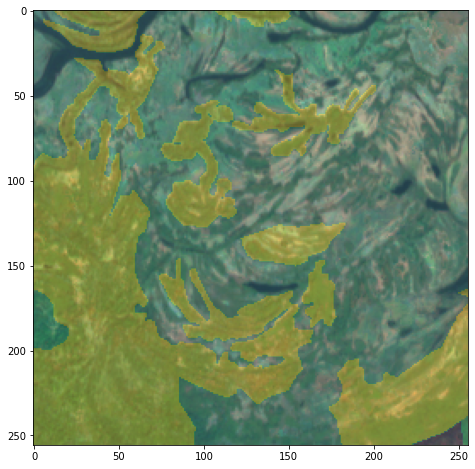

In [81]:
import random
index = 76
seed = random.randint(0,1000)
image_index = labelled_dataset._get_image_index(index)
tile_bounds = labelled_dataset._get_tile_bounds(index)

image = labelled_dataset._get_tile_from_bounds(image_index, *tile_bounds, mode="image")
label = labelled_dataset._get_tile_label(*tile_bounds, mode="raster")

print(f"Image shape: {image.shape} and type {type(image)} with {image.dtype}")
print(f"Label shape: {label.shape} and type {type(label)} with {label.dtype}")

import torch

augment = lambda image, seed: reshape_as_image(np.array(labelled_dataset._augment(torch.from_numpy(reshape_as_raster(image)), seed)))
augment_raster = lambda raster, seed: np.array(labelled_dataset._augment(torch.from_numpy(raster), seed)).squeeze()

fig, ax = plt.subplots(1, figsize=(8,8))

plt.imshow(augment(image*2, seed))
plt.imshow(augment_raster(label, seed), alpha=0.3)

In [91]:
def inspect_tile(index, overlay_label = True, dataset=labelled_dataset):
    
    fig, ax = plt.subplots(1)
    
    dataset.tile_mode = "image"
    dataset.label_mode = "image"
    dataset.use_augmentations = False
    image_index = dataset._get_image_index(index)
    tile_bounds = dataset._get_tile_bounds(index)
    print(f"Image {image_index}, with name: {dataset.names[image_index]}")
    print(f"Bounds: {tile_bounds}")
    
    image, label = dataset[index]
    
    plt.imshow(image)
    
    if overlay_label:
        plt.imshow(label, 
                   alpha=0.4)


    dataset.tile_mode = "tensor"
    dataset.label_mode = "one-hot"
    plt.show()

Image 3, with name: S2_pol_2019_OND
Bounds: (4096, 3584, 4352, 3840)


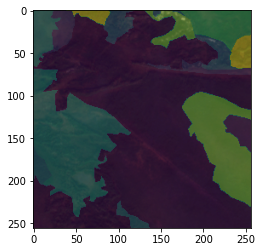

In [97]:
inspect_tile(3000, overlay_label=True)

In [98]:
label_onehot_tensor = torch.nn.functional.one_hot(label_tensor, num_classes=len(unique_labels))

In [57]:
img = SatelliteImage(shard_paths['S2_pol_2017_AMJ'])
rgb_vals = [2,1,0]

In [58]:
img.combined_image

,Array,Chunk
Bytes,7.57 GB,524.29 kB
Shape,"(10, 8351, 11324)","(1, 256, 256)"
Count,44554 Tasks,14850 Chunks
Type,float64,numpy.ndarray


#### Briefly inspect a sample tile and its labels to check if they correspond

In [16]:
area_to_query = (slice(256*5,256*6), slice(256*5, 256*6))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


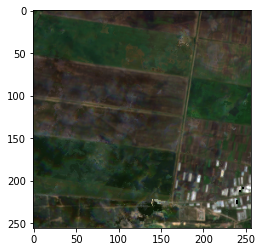

In [27]:
plt.imshow(reshape_as_image(img[(rgb_vals, *area_to_query)].compute()) / 3000)

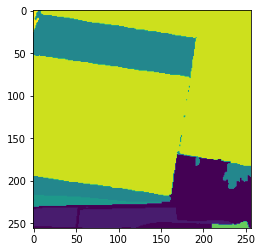

In [157]:
plt.imshow(labels[((0, *area_to_query))].compute())

In [28]:
np.sum(dataset.tile_label_overlaps > 0.7)

840

Text(0.5, 1.0, 'Tile-Label overlap fraction')

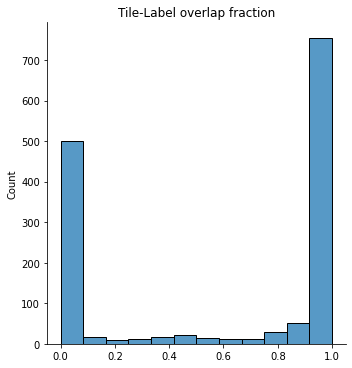

In [29]:
sns.displot(dataset.tile_label_overlaps)
plt.title("Tile-Label overlap fraction")

In [32]:
dataset.tile_center_coords[dataset.tile_label_overlaps > 0.7]

array([[ 384, 2176],
       [ 640, 1664],
       [ 640, 1920],
       ...,
       [7808, 4224],
       [7808, 4480],
       [7808, 4736]])